In [1]:
import os
import shutil
import random
import numpy as np

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import seaborn as sn
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from matplotlib.path import Path
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

from keras.optimizers import Adam

from dltk.io.augmentation import *

from src.bi_classifier3D import Biclassifier3D

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


Data loading and preprocessing

In [2]:
# dirpath = "./data"
# if os.path.exists(dirpath) and os.path.isdir(dirpath):
#     shutil.rmtree(dirpath)

In [3]:
from src.arrange_dataset import arrange_dataset

data_dir = arrange_dataset() 
print(data_dir)

Dataset arranged in ./data
./data


In [4]:
from src.data_loader3D import NiiSequence, dataGenerator
from sklearn.model_selection import train_test_split

batch_size = 16
nb_classes = 4

train_set, train_labels = dataGenerator(data_dir, mode="train", nb_classes=nb_classes)
test_set, test_labels = dataGenerator(data_dir, mode="val", nb_classes=nb_classes)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, test_size=0.2, random_state=42, shuffle=True)

print("Train set size: ", len(train_set))
print("Validation set size: ", len(val_set))
print("Test set size: ", len(test_set))

Train set size:  457
Validation set size:  115
Test set size:  146


In [5]:
def check_CN(path):
    return "CN" in path

def check_SMCI(path):
    return "SMCI" in path

def check_PMCI(path):
    return "PMCI" in path

def check_AD(path):
    return "AD" in path

train = [0]*4
train[0] = list(filter(check_CN,train_set))
train[1] = list(filter(check_SMCI,train_set))
train[2] = list(filter(check_PMCI,train_set))
train[3] = list(filter(check_AD,train_set))

lst = [len(train[0]), len(train[1]), len(train[2]), len(train[3])]

max_class = lst.index(max(lst))
max_len = lst[max_class]

train_labels=[]
train_set = []
for i in range(4):
    diff = max_len - len(train[i])
    more_data = train[i][:diff]
    if more_data:
        train[i].extend(more_data)
    train_set.extend(train[i])
    train_labels+= [i]*max_len

zipped = list(zip(train_set, train_labels))
random.shuffle(zipped)
train_set, train_labels = zip(*zipped)

train_labels = np.array(train_labels)

In [6]:
print(len(train[0]),len(train[1]), len(train[2]), len(train[3]))
assert len(train[0]) ==len(train[1]) ==len(train[2]) ==len(train[3])

141 141 141 141


In [7]:
train_sequence = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset', 'gaussian_noise', 'shiftIntensity', 'adjustContrast'])
val_sequence = NiiSequence(val_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False)
test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)

print("Shape of one MRI element:", train_sequence[0][0].shape)
print("Train label example after loading:", train_sequence[0][1])

print("Shape of one batch:", test_sequence[0][0].shape)
print("Test label example after loading:", test_sequence[0][1])

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]
Shape of one batch: (16, 40, 40, 80, 1)
Test label example after loading: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [8]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (15, 40, 40, 80, 1)
Train label example after loading: (15, 4)


Scan Visualization

282


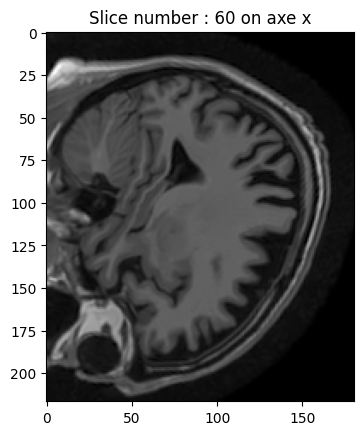

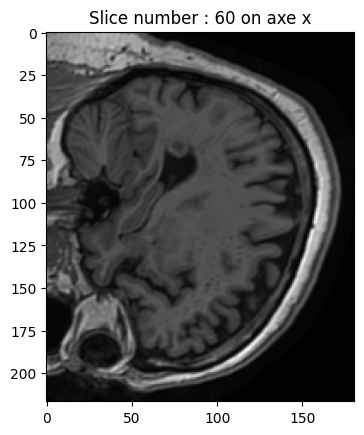

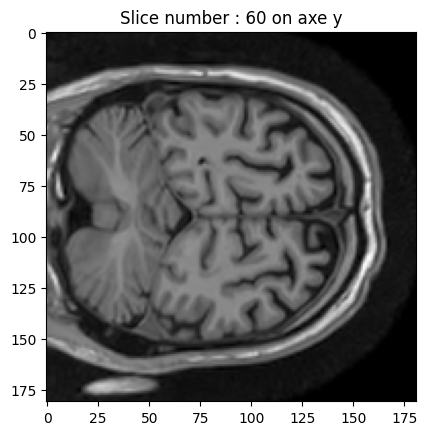

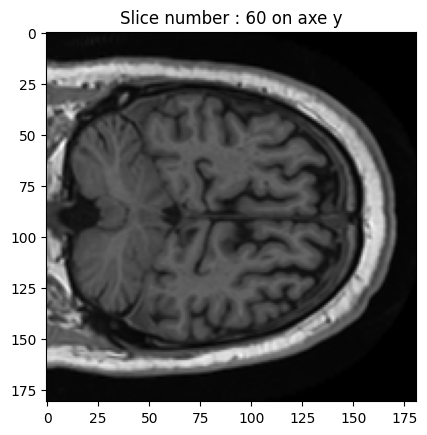

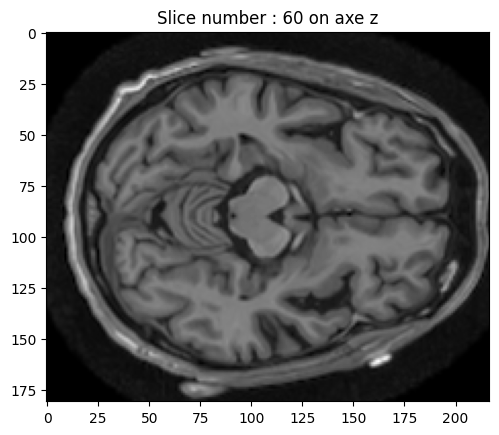

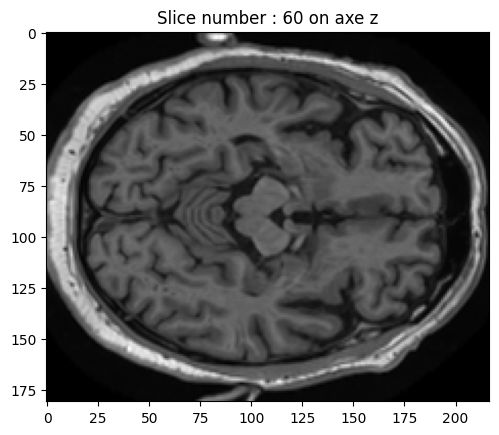

In [9]:
# MRI images are composed by many slices, build a montage of the them
def show_2D(irm, slice, axe):
    if axe == "x":
        plt.imshow(irm[slice,:,:], cmap="gray")
    elif axe == "y":
        plt.imshow(irm[:,slice,:], cmap="gray")
    elif axe == "z":
        plt.imshow(irm[:,:,slice], cmap="gray")
    plt.title("Slice number : " + str(slice) + " on axe " + axe)
    plt.show()

firstAug = int(train_set.__len__()/2)
img = nib.load(train_set[0])
print(firstAug)
img2 = nib.load(train_set[firstAug])

show_2D(img.get_fdata(), 60, "x")
show_2D(img2.get_fdata(), 60, "x")

show_2D(img.get_fdata(), 60, "y")
show_2D(img2.get_fdata(), 60, "y")

show_2D(img.get_fdata(), 60, "z")
show_2D(img2.get_fdata(), 60, "z")

Imbalanced Data

# 3D Convolutional Neural Network without data augmentation

In [10]:
from src.bi_classifier3D import Biclassifier3D

input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
print("Input shape:", input_shape)
bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
model = bicl.build_model()
model.summary()
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy'],
)

Input shape: (40, 40, 80, 1)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization (BatchN  (None, 40, 40, 80, 8)    32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_1 (Activation)   (None, 40, 40, 80, 8)     0         
                                

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model training

In [11]:
# checkpoint
filepath="classifier3D-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)

callbacks_list = [checkpoint, early_stop, reduce_lr]

In [12]:
model.fit(
    train_sequence,
    validation_data=val_sequence,
    validation_steps=len(val_set) // batch_size,
    callbacks=callbacks_list,
    epochs=10,
)

Epoch 1/10
36/36 [==============================] - ETA: 0s - loss: 1.4287 - accuracy: 0.2447
Epoch 1: val_accuracy improved from -inf to 0.30357, saving model to classifier3D-01-0.30.hdf5
36/36 [==============================] - 114s 3s/step - loss: 1.4287 - accuracy: 0.2447 - val_loss: 1.3698 - val_accuracy: 0.3036 - lr: 1.0000e-04
Epoch 2/10
36/36 [==============================] - ETA: 0s - loss: 1.3311 - accuracy: 0.3706
Epoch 2: val_accuracy improved from 0.30357 to 0.35714, saving model to classifier3D-02-0.36.hdf5
36/36 [==============================] - 100s 3s/step - loss: 1.3311 - accuracy: 0.3706 - val_loss: 1.3393 - val_accuracy: 0.3571 - lr: 1.0000e-04
Epoch 3/10
36/36 [==============================] - ETA: 0s - loss: 1.2846 - accuracy: 0.3989
Epoch 3: val_accuracy improved from 0.35714 to 0.48214, saving model to classifier3D-03-0.48.hdf5
36/36 [==============================] - 107s 3s/step - loss: 1.2846 - accuracy: 0.3989 - val_loss: 1.2687 - val_accuracy: 0.4821 - l

Visualizing Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


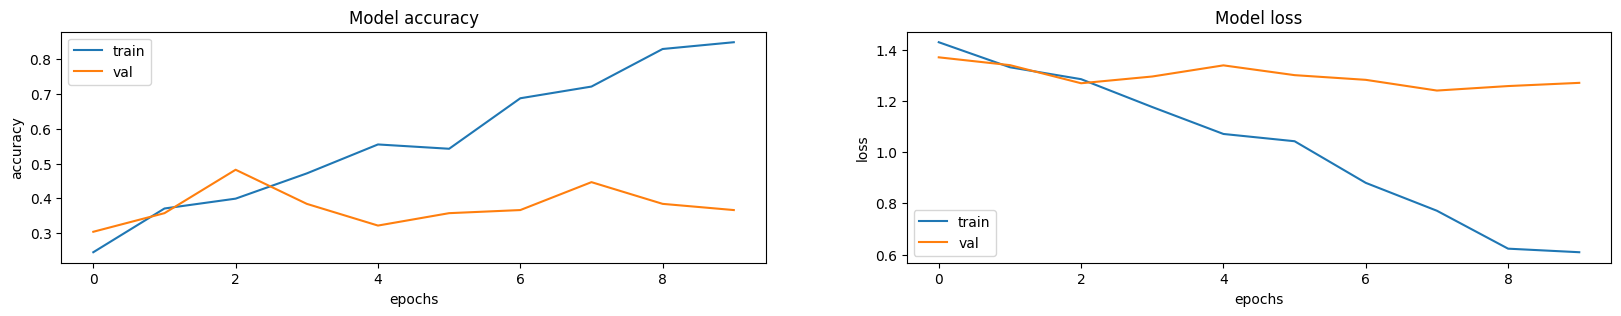

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

print(model.history.history.keys())
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history[f'val_{metric}'])
    ax[i].set_title(f'Model {metric}')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

Model Evaluation

In [14]:
# test_sequence = NiiSequence(test_set, batch_size, nb_classes=nb_classes, mode="HC", shuffle=False)
model.evaluate(test_sequence, verbose=1)

10/10 [==============================] - 19s 2s/step - loss: 1.3350 - accuracy: 0.4041


[1.3349943161010742, 0.4041095972061157]

In [15]:
y = model.predict(test_sequence)

10/10 [==============================] - 20s 2s/step


In [16]:
y_pred = y.argmax(axis=1)
y_test = np.array(test_labels)
print(y_pred)
print(y_test)

[2 1 0 0 1 2 0 0 1 2 3 1 1 0 1 1 0 3 3 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 1
 0 0 1 1 1 0 1 1 1 3 3 1 1 1 0 3 2 1 3 3 0 0 1 0 1 1 0 0 1 3 3 3 3 1 3 3 3
 1 3 3 3 3 1 2 3 3 2 2 3 3 3 3 3 3 2 3 3 0 1 2 3 1 3 0 1 1 3 2 3 2 3 3 3 2
 3 1 3 1 2 3 0 1 0 3 3 0 3 3 2 3 3 3 3 1 3 0 3 3 3 0 3 3 3 2 3 3 3 3 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [17]:
def calcul_metrics(y_pred,y_true):
    print("Precision", precision_score(y_true, y_pred, average='macro'))
    print("Recall", recall_score(y_true, y_pred, average='macro'))
    print("f1_score", f1_score(y_true, y_pred, average='macro'))

In [18]:
calcul_metrics(y_pred,y_test)

Precision 0.4171729597927236
Recall 0.3946209587513936
f1_score 0.3815407263494299


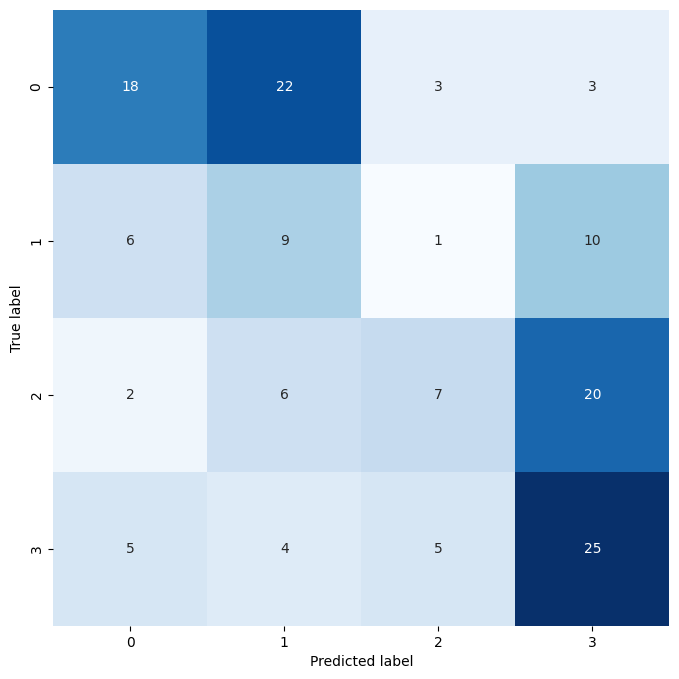

In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

36/36 [==============================] - 83s 2s/step
Precision 0.8495828299943258
Recall 0.8333333333333334
f1_score 0.8327641440921547


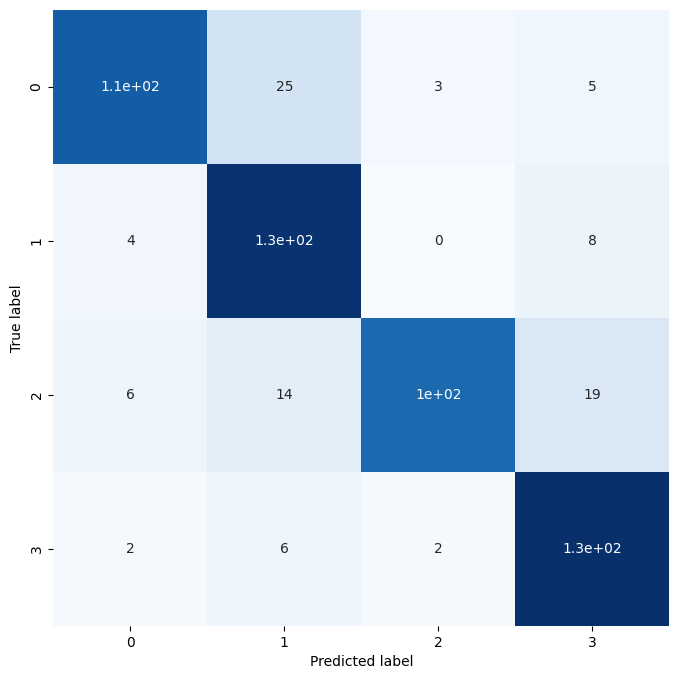

In [20]:
y = model.predict(train_sequence)
y_pred = y.argmax(axis=1)
y_train = np.array(train_labels)

calcul_metrics(y_pred,y_train)

cm = confusion_matrix(y_train, y_pred)
cm_ = cm / cm.astype(float).sum(axis=1) * 100
plt.figure(figsize=(8, 8))
sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Neural network with data augmentation

In [21]:
def fonc_training(train_sequence_aug):
    input_shape = (train_sequence[0][0].shape[1], train_sequence[0][0].shape[2], train_sequence[0][0].shape[3], train_sequence[0][0].shape[4])
    print("Input shape:", input_shape)
    bicl = Biclassifier3D(input_shape, n_classes=nb_classes, n_filters=8, kernel_size=3, activation='relu', dropout=0.4)
    model = bicl.build_model()
    model.summary()
    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=1e-3),
        metrics=['accuracy'],
    )
    # checkpoint
    filepath="classifcier3D-dataAug-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1)
    callbacks_list = [checkpoint, early_stop]
    
    model.fit(
        train_sequence_aug,
        validation_data=val_sequence,
        validation_steps=len(val_set) // batch_size,
        callbacks=callbacks_list,
        epochs=10,
    )
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()
    
    print(model.history.history.keys())
    for i, metric in enumerate(['accuracy', 'loss']):
        ax[i].plot(model.history.history[metric])
        ax[i].plot(model.history.history[f'val_{metric}'])
        ax[i].set_title(f'Model {metric}')
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(metric)
        ax[i].legend(['train', 'val'])

    return model

In [22]:
def fonc_eval(model):
    model.evaluate(test_sequence, verbose=1)
    
    y = model.predict(test_sequence)
    y_pred = y.argmax(axis=1)
    y_test = np.array(test_labels)
    
    calcul_metrics(y_pred,y_test)
    
    cm = confusion_matrix(y_test, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

In [23]:
def fonc_predict_train(model):
    y = model.predict(train_sequence)
    y_pred = y.argmax(axis=1)
    y_train = np.array(train_labels)
    
    calcul_metrics(y_pred,y_train)
    
    cm = confusion_matrix(y_train, y_pred)
    cm_ = cm / cm.astype(float).sum(axis=1) * 100
    plt.figure(figsize=(8, 8))
    sn.heatmap(cm, annot=True, square=True, cmap='Blues', cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

### Gaussian offset

In [24]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_offset'])

In [25]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_4 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_1 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_5 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_6 (Activation)   (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 1.6400 - accuracy: 0.2704 
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to classifcier3D-dataAug-01-0.25.hdf5
71/71 [==============================] - 1027s 15s/step - loss: 1.6400 - accuracy: 0.2704 - val_loss: 1.3784 - val_accuracy: 0.2500
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.3192 - accuracy: 0.3599
Epoch 2: val_accuracy did not improve from 0.25000
71/71 [==============================] - 109s 2s/step - loss: 1.3192 - accuracy: 0.3599 - val_loss: 1.4367 - val_accuracy: 0.2500
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.0980 - accuracy: 0.5080
Epoch 3: val_accuracy improved from 0.25000 to 0.39286, saving model to classifcier3D-dataAug-03-0.39.hdf5
71/71 [==============================] - 112s 2s/step - loss: 1.0980 - accuracy: 0.5080 - val_loss: 1.3010 - val_accuracy: 0.3929
Epoch 4/10
71/71 [==============================] - ETA: 0s - l

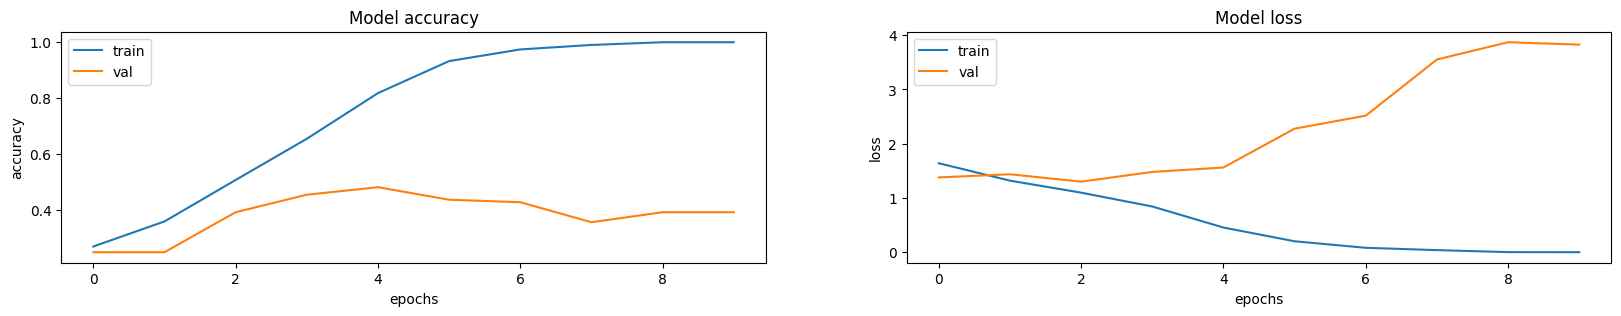

In [26]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.40528846153846154
Recall 0.4080387004300048
f1_score 0.4054076664745742


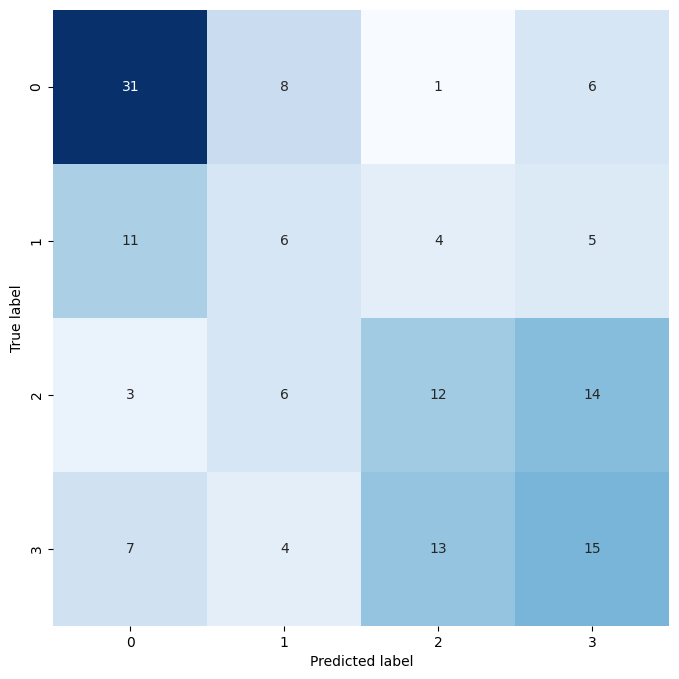

In [27]:
fonc_eval(model)

36/36 [==============================] - 81s 2s/step
Precision 1.0
Recall 1.0
f1_score 1.0


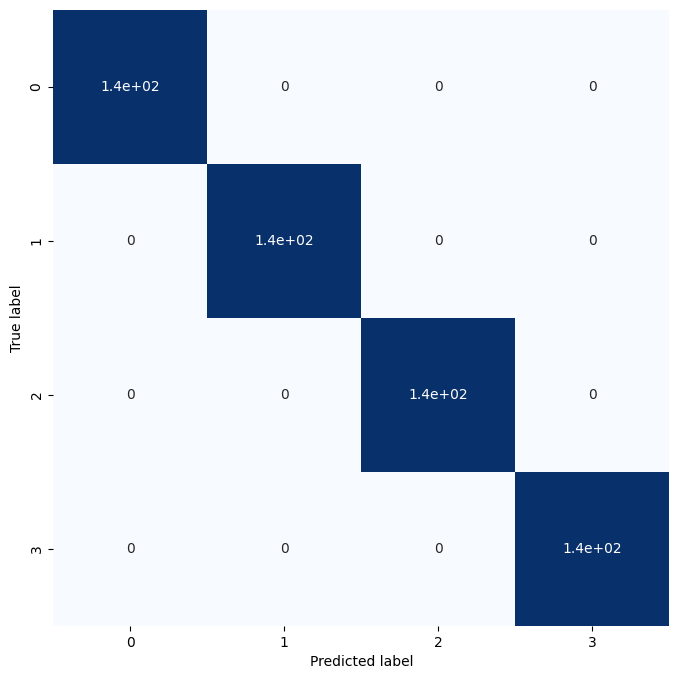

In [28]:
fonc_predict_train(model)

### Gaussian noise

In [29]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['gaussian_noise'])

In [30]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_2 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_11 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 1.5574 - accuracy: 0.2137 
Epoch 1: val_accuracy improved from -inf to 0.18750, saving model to classifcier3D-dataAug-01-0.19.hdf5
71/71 [==============================] - 3089s 44s/step - loss: 1.5574 - accuracy: 0.2137 - val_loss: 1.3864 - val_accuracy: 0.1875
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.3868 - accuracy: 0.2482
Epoch 2: val_accuracy improved from 0.18750 to 0.25000, saving model to classifcier3D-dataAug-02-0.25.hdf5
71/71 [==============================] - 111s 2s/step - loss: 1.3868 - accuracy: 0.2482 - val_loss: 1.3860 - val_accuracy: 0.2500
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.3866 - accuracy: 0.2340
Epoch 3: val_accuracy did not improve from 0.25000
71/71 [==============================] - 118s 2s/step - loss: 1.3866 - accuracy: 0.2340 - val_loss: 1.3864 - val_accuracy: 0.2143
Epoch 4/10
71/71 [==============================] - ETA: 0s - l

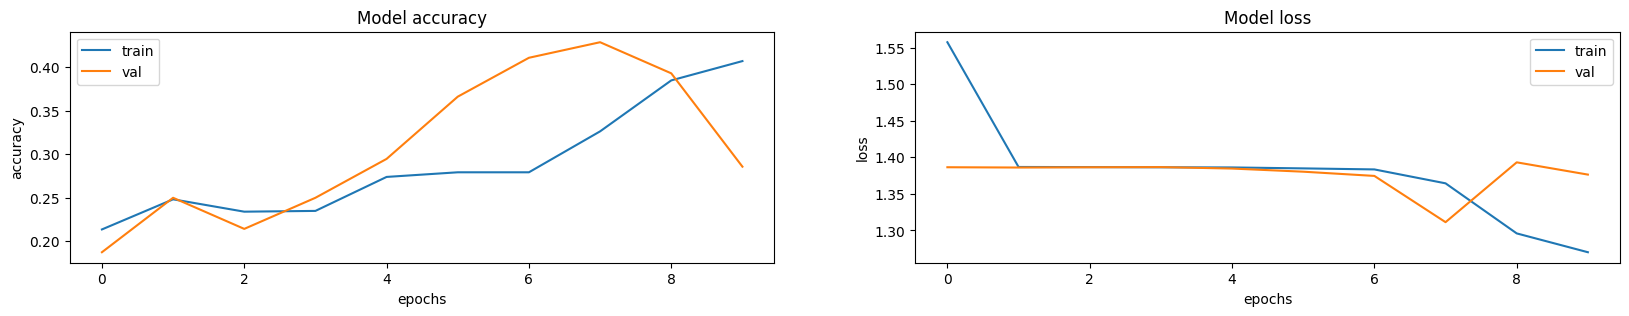

In [31]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.37452209592353536
Recall 0.33682513139034875
f1_score 0.316239954075775


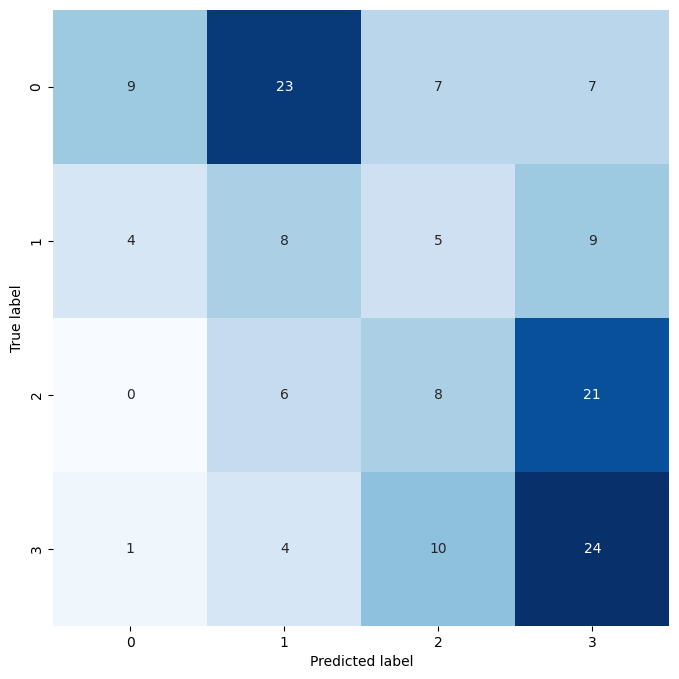

In [32]:
fonc_eval(model)

36/36 [==============================] - 83s 2s/step
Precision 0.5794783914349132
Recall 0.5124113475177305
f1_score 0.4960269288007381


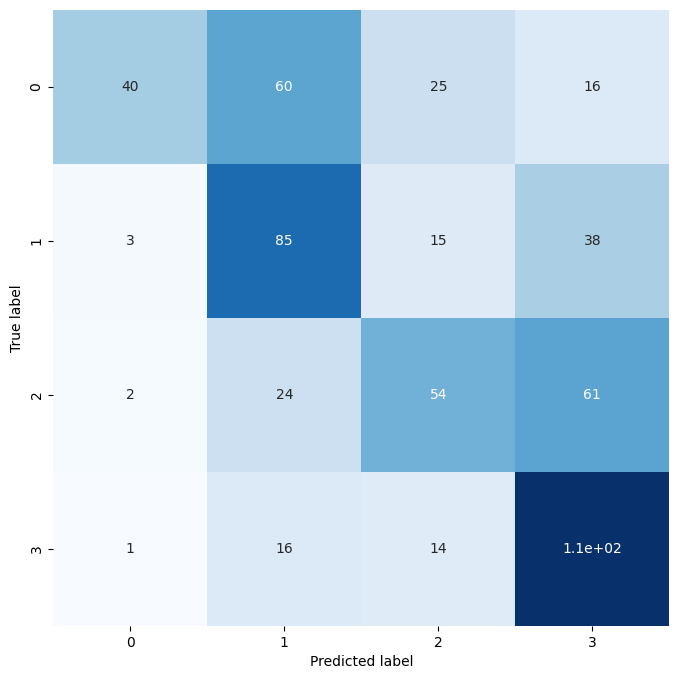

In [33]:
fonc_predict_train(model)

### Shift intensity

In [34]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['shiftIntensity'])

In [35]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_12 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_3 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_15 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_16 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 1.8508 - accuracy: 0.2491
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to classifcier3D-dataAug-01-0.25.hdf5
71/71 [==============================] - 118s 2s/step - loss: 1.8508 - accuracy: 0.2491 - val_loss: 1.3861 - val_accuracy: 0.2500
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.3850 - accuracy: 0.2801
Epoch 2: val_accuracy improved from 0.25000 to 0.38393, saving model to classifcier3D-dataAug-02-0.38.hdf5
71/71 [==============================] - 108s 2s/step - loss: 1.3850 - accuracy: 0.2801 - val_loss: 1.3768 - val_accuracy: 0.3839
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.3820 - accuracy: 0.2828
Epoch 3: val_accuracy did not improve from 0.38393
71/71 [==============================] - 118s 2s/step - loss: 1.3820 - accuracy: 0.2828 - val_loss: 1.3740 - val_accuracy: 0.3214
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss

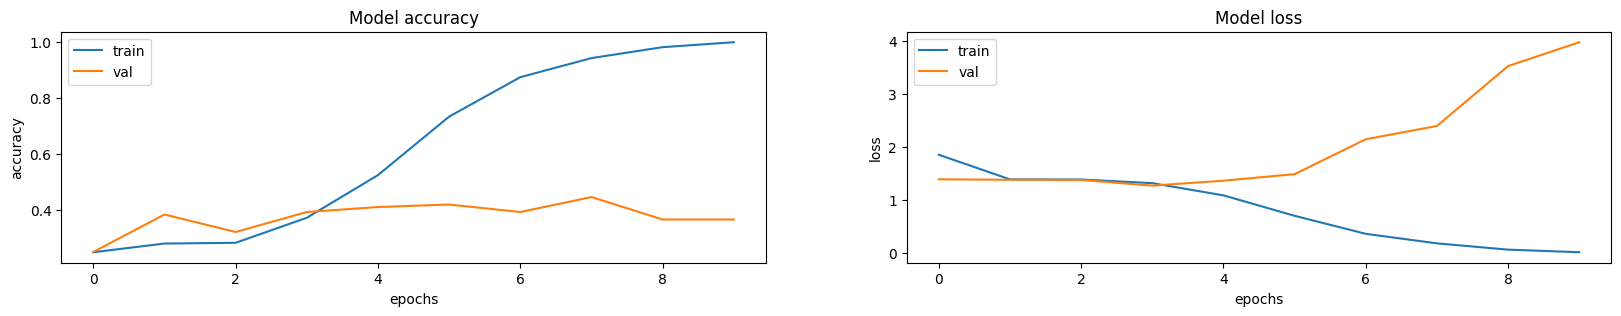

In [36]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 2169s 241s/step
Precision 0.3421085858585859
Recall 0.3309483994266603
f1_score 0.3200478925335345


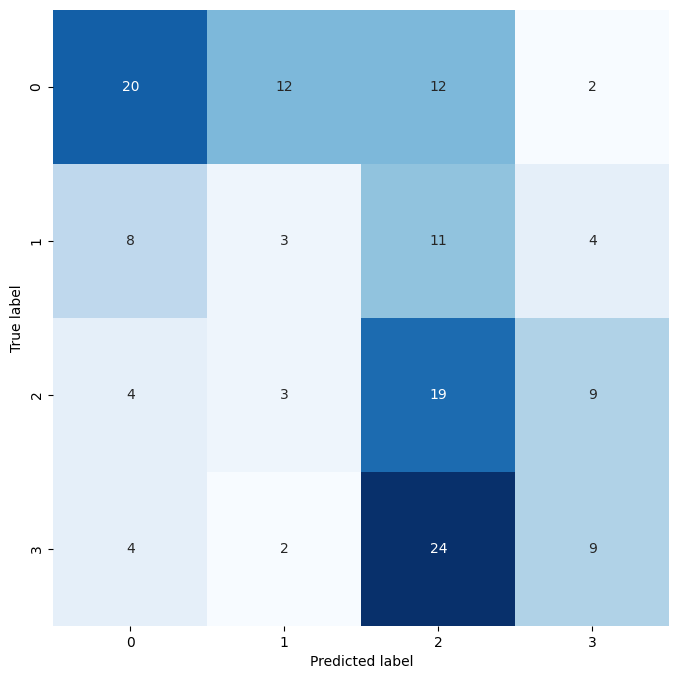

In [37]:
fonc_eval(model)

36/36 [==============================] - 85s 2s/step
Precision 1.0
Recall 1.0
f1_score 1.0


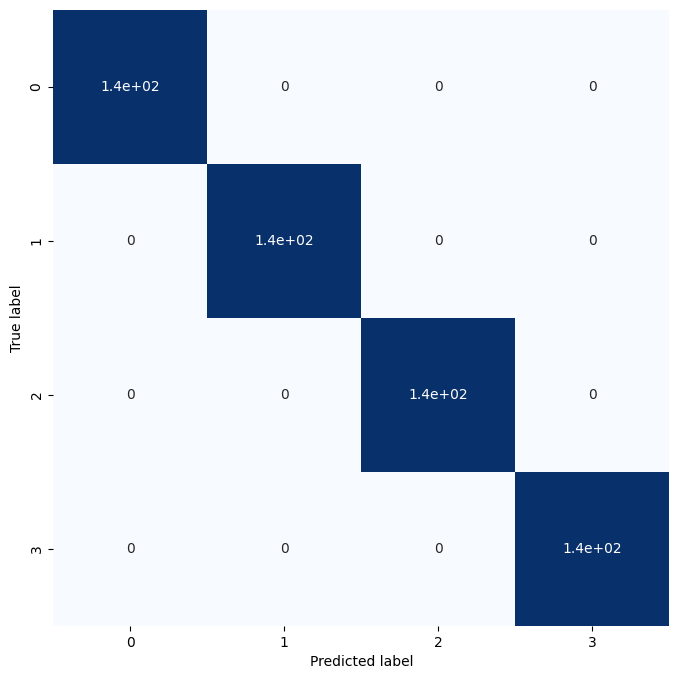

In [38]:
fonc_predict_train(model)

### Adjuste contrast

In [39]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['adjustContrast'])

In [40]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_4 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_20 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_17 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_21 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.2358
Epoch 1: val_accuracy improved from -inf to 0.33036, saving model to classifcier3D-dataAug-01-0.33.hdf5
71/71 [==============================] - 108s 2s/step - loss: 1.9193 - accuracy: 0.2358 - val_loss: 1.3833 - val_accuracy: 0.3304
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.3789 - accuracy: 0.3014
Epoch 2: val_accuracy improved from 0.33036 to 0.38393, saving model to classifcier3D-dataAug-02-0.38.hdf5
71/71 [==============================] - 105s 1s/step - loss: 1.3789 - accuracy: 0.3014 - val_loss: 1.3244 - val_accuracy: 0.3839
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.2982 - accuracy: 0.3945
Epoch 3: val_accuracy did not improve from 0.38393
71/71 [==============================] - 108s 2s/step - loss: 1.2982 - accuracy: 0.3945 - val_loss: 1.4888 - val_accuracy: 0.1964
Epoch 4/10
71/71 [==============================] - ETA: 0s - loss

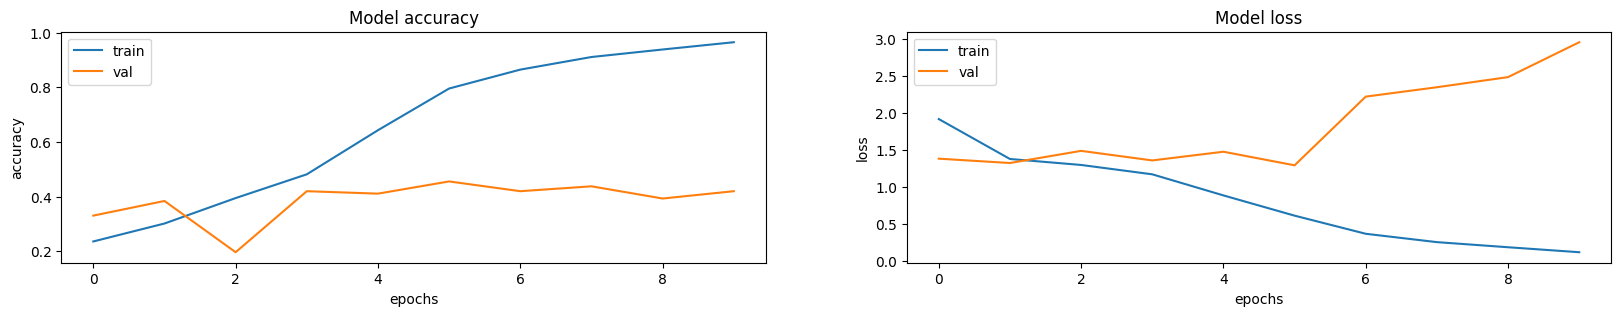

In [41]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.3572610185513411
Recall 0.36206004140786746
f1_score 0.3465801784631378


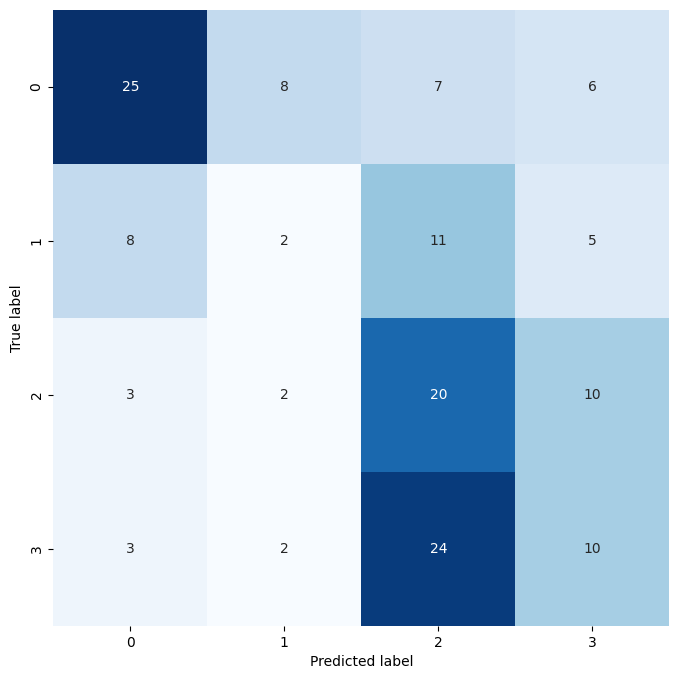

In [42]:
fonc_eval(model)

36/36 [==============================] - 830s 24s/step
Precision 1.0
Recall 1.0
f1_score 1.0


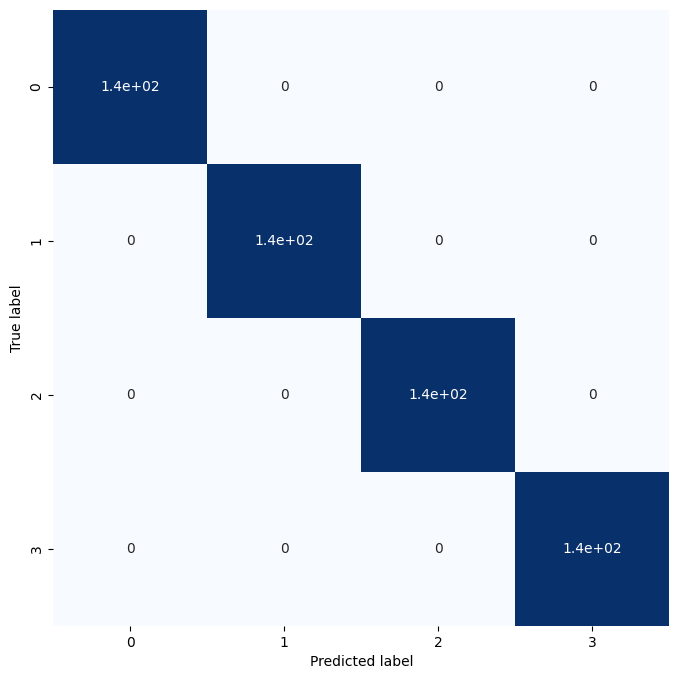

In [43]:
fonc_predict_train(model)

### RandBiasField

In [44]:
train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['randBiasField'])

In [45]:
print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
print("Train label example after loading:", train_sequence_aug[0][1].shape)

Shape of one MRI element: (16, 40, 40, 80, 1)
Train label example after loading: (16, 4)


Input shape: (40, 40, 80, 1)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40, 40, 80, 1)]   0         
                                                                 
 conv3d_20 (Conv3D)          (None, 40, 40, 80, 8)     224       
                                                                 
 batch_normalization_5 (Batc  (None, 40, 40, 80, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_25 (Activation)  (None, 40, 40, 80, 8)     0         
                                                                 
 conv3d_21 (Conv3D)          (None, 40, 40, 80, 8)     1736      
                                                                 
 activation_26 (Activation)  (None, 40, 40, 80, 8)     0         
                              

/home/priscilla/.local/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
71/71 [==============================] - ETA: 0s - loss: 2.5011 - accuracy: 0.2748
Epoch 1: val_accuracy improved from -inf to 0.21429, saving model to classifcier3D-dataAug-01-0.21.hdf5
71/71 [==============================] - 110s 2s/step - loss: 2.5011 - accuracy: 0.2748 - val_loss: 1.3916 - val_accuracy: 0.2143
Epoch 2/10
71/71 [==============================] - ETA: 0s - loss: 1.3420 - accuracy: 0.3387
Epoch 2: val_accuracy improved from 0.21429 to 0.22321, saving model to classifcier3D-dataAug-02-0.22.hdf5
71/71 [==============================] - 103s 1s/step - loss: 1.3420 - accuracy: 0.3387 - val_loss: 1.4453 - val_accuracy: 0.2232
Epoch 3/10
71/71 [==============================] - ETA: 0s - loss: 1.1954 - accuracy: 0.4814
Epoch 3: val_accuracy improved from 0.22321 to 0.38393, saving model to classifcier3D-dataAug-03-0.38.hdf5
71/71 [==============================] - 109s 2s/step - loss: 1.1954 - accuracy: 0.4814 - val_loss: 1.4377 - val_accuracy: 0.3839
Epoch 4/10

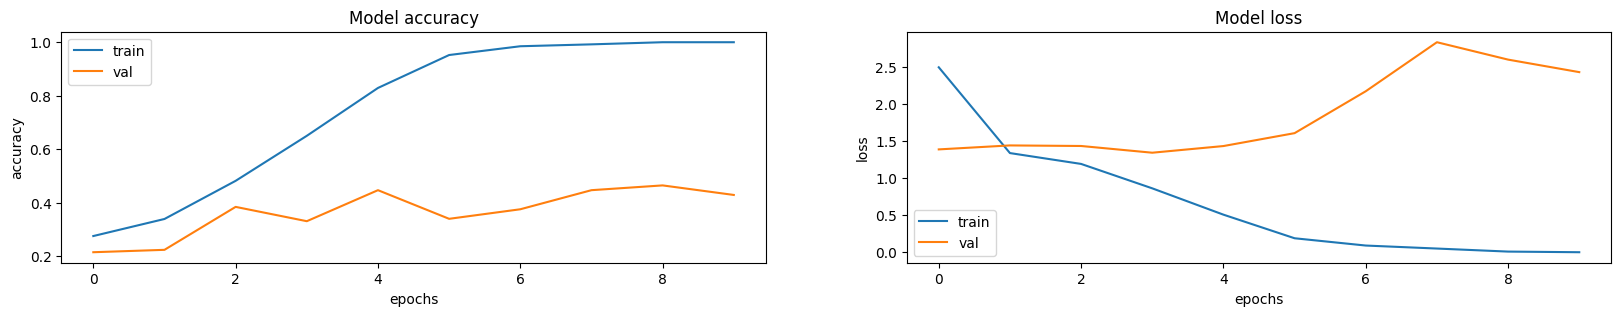

In [46]:
model =fonc_training(train_sequence_aug)

10/10 [==============================] - 21s 2s/step
Precision 0.36444805194805197
Recall 0.3718028348463131
f1_score 0.36511725694817704


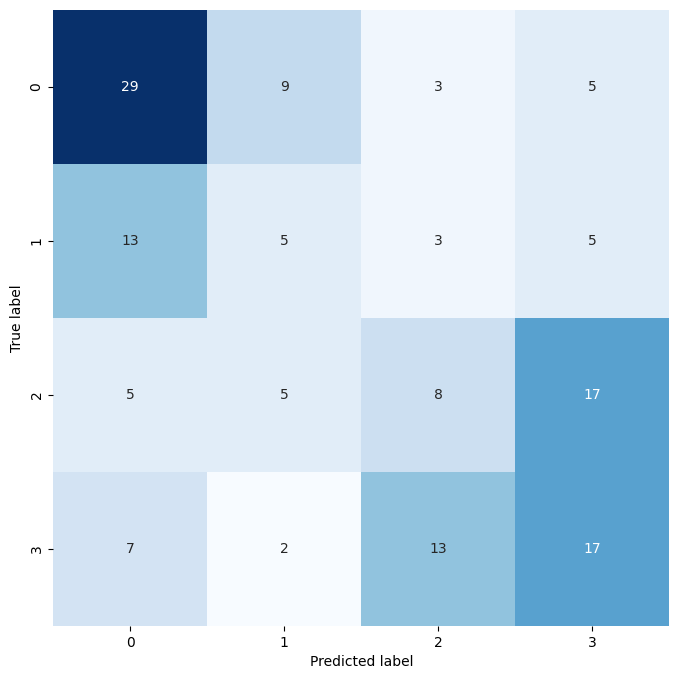

In [47]:
fonc_eval(model)

36/36 [==============================] - 87s 2s/step
Precision 1.0
Recall 1.0
f1_score 1.0


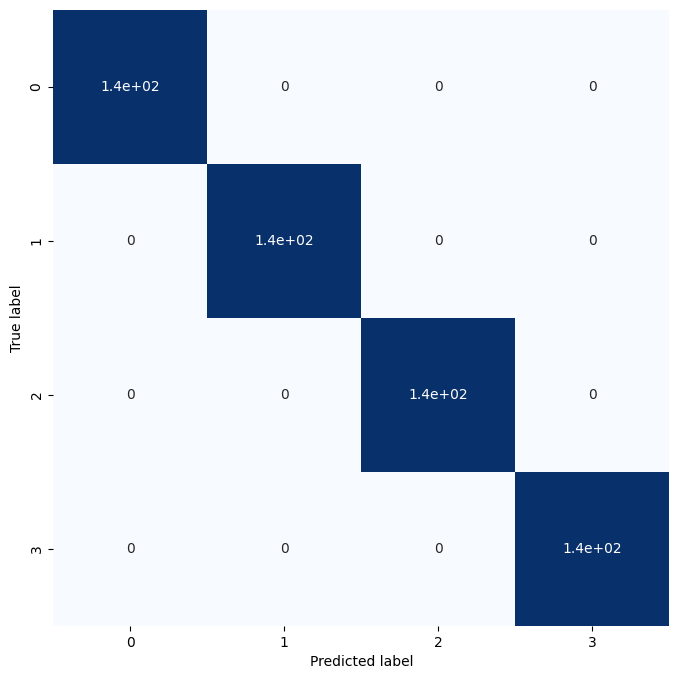

In [48]:
fonc_predict_train(model)

### rand3DElastic

In [49]:
# train_sequence_aug = NiiSequence(train_set, batch_size, nb_classes=nb_classes, mode="HC",shuffle=False, data_aug=['rand3DElastic'])

In [50]:
# print("Shape of one MRI element:", train_sequence_aug[0][0].shape)
# print("Train label example after loading:", train_sequence_aug[0][1].shape)

In [51]:
# model =fonc_training(train_sequence_aug)

In [52]:
# fonc_eval(model)

In [53]:
# fonc_predict_train(model)